### Introduction 
In this exercise you will work with stock market data. We use the data available at [Yahoo Finance](https://finance.yahoo.com/quote/DAX/history?period1=1478390400&period2=1604534400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)
You will build sequential models to predict the variations for Global X DAX Germany ETF (DAX). The goal is to predict whether the stock value is higher or lower than its actual value of previous day.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

### Loading and Preprocessing Data

In [2]:
# Load dataset
# path="https://github.com/murpi/wilddata/blob/master/quests/dax/"
path="https://raw.githubusercontent.com/murpi/wilddata/master/quests/dax/"

In [3]:
# Loading training data
training_data = pd.read_csv(path + "dax_train_2019.csv.txt", sep=",", index_col="date", parse_dates=True)

# Below I found that the data is provided per every business day
# so I am using "Business Day" as the correct periods
training_data.index.to_period("B")

# Checking out columns and shape of the dataset
print(f"Training data column info:\n{training_data.dtypes}")
print(f"Training data shape is {training_data.shape}")

Training data column info:
open         float64
high         float64
low          float64
close        float64
adj_close    float64
volume         int64
dtype: object
Training data shape is (644, 6)


In [4]:
# Loading testing data
testing_data = pd.read_csv(path + "dax_test_2019.csv.txt", sep=",", index_col="date", parse_dates=True)
training_data.index.to_period("B")
print(f"Testing data column info:\n{testing_data.dtypes}")
print(f"Testing data shape is {testing_data.shape}")

Testing data column info:
open         float64
high         float64
Low          float64
close        float64
adj_close    float64
volume         int64
dtype: object
Testing data shape is (148, 6)


In [5]:
training_data.head()

,open,high,low,close,adj_close,volume
date,,,,,,
2016-11-07,24.340000,24.440001,24.304001,24.400000,22.092239,2700
2016-11-08,24.559999,24.559999,24.520000,24.530001,22.209948,1100
2016-11-09,24.296000,24.610001,24.296000,24.590000,22.264271,900
2016-11-10,24.750000,24.750000,24.360001,24.474001,22.159245,4600
2016-11-11,24.410000,24.537001,24.410000,24.440001,22.128456,2700


`low` feature in testing data is named with capital "L", renaming...:

In [6]:
# Fixing the capital letter L in "Low"
testing_data.rename(columns={"Low": "low"}, inplace=True)

In [7]:
testing_data.head()

,open,high,low,close,adj_close,volume
date,,,,,,
2019-06-03,25.660000,25.830000,25.650000,25.825001,24.876635,10700
2019-06-04,26.150000,26.166000,25.889999,26.090000,25.131905,10400
2019-06-05,26.115999,26.115999,26.115999,26.115999,25.156948,100
2019-06-06,26.326000,26.326000,26.326000,26.326000,25.359238,400
2019-06-07,26.549999,26.600000,26.223000,26.540001,25.565380,5300


In [8]:
# Now I will make a test to check whether the index of a given dataframe
# is conform to a "Business Day" frequency offsets

def check_bdays(df):

    # Initialize offset object
    bday = pd.tseries.offsets.BDay()
    
    # We will count dates in indexes that match the offset
    count = 0

    # Check all dates in the index
    for index_date in df.index:
        if not bday.is_on_offset(index_date):
            print(f"Index {index_date} is not a business day")
        else:
            # print(f"Index {index_date} is a business day")
            count += 1

    print(f"I've seen {count} business days in the index.")
    print(f"Number of total rows in the data = {df.shape[0]}")

In [9]:
check_bdays(training_data)
check_bdays(testing_data)

I've seen 644 business days in the index.
Number of total rows in the data = 644
I've seen 148 business days in the index.
Number of total rows in the data = 148


All the entries were observed during business days.

####  Are there any NaN values in training and testing data sets?

In [10]:
# Checking out NaN values in both dataframes
print(f"Training set NaN count : {training_data.isna().sum().sum()}")
print(f"Testing set NaN count  : {testing_data.isna().sum().sum()}")

Training set NaN count : 0
Testing set NaN count  : 0


It is apparent that all features except _volume_ are mutually correlated.

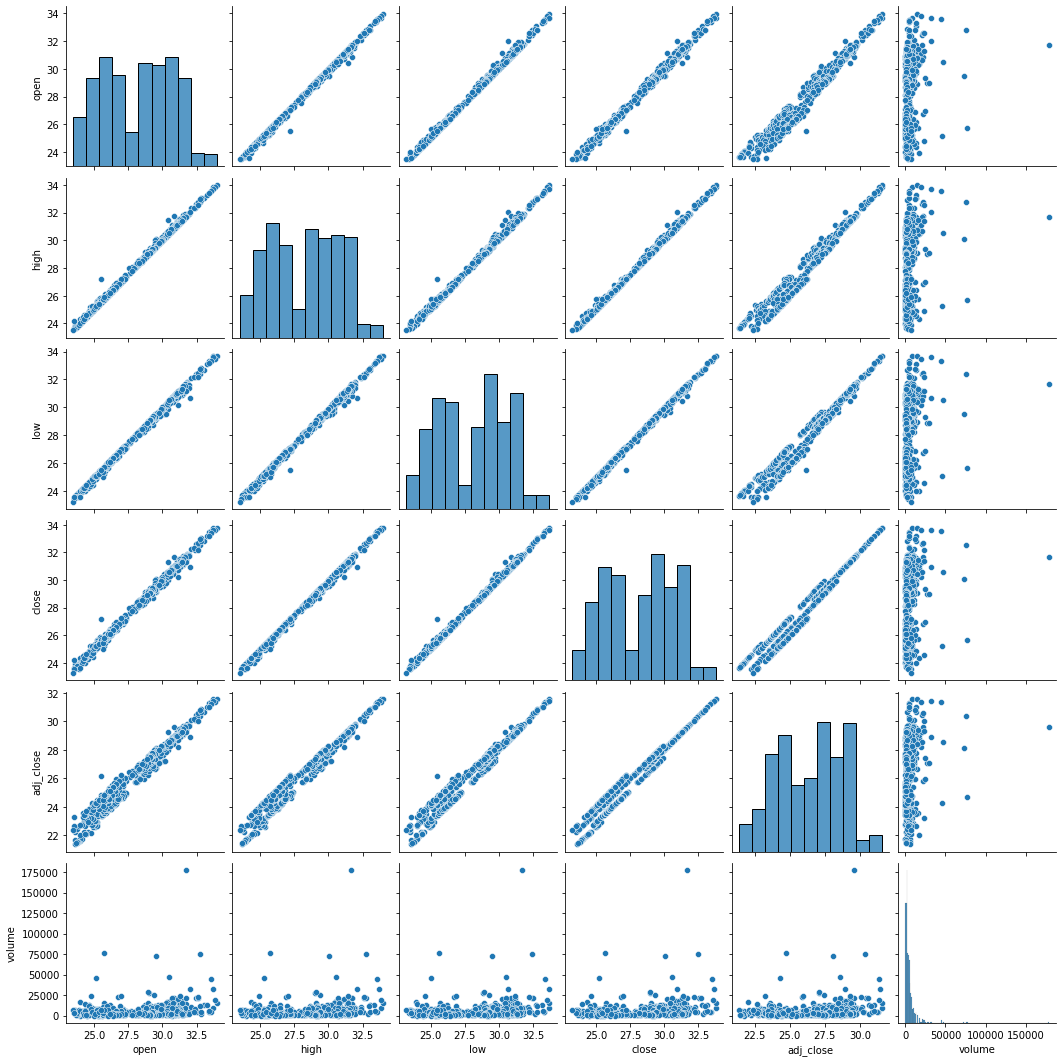

In [11]:
# g is an object of PairGrid class
g = sns.pairplot(training_data)
plt.show()

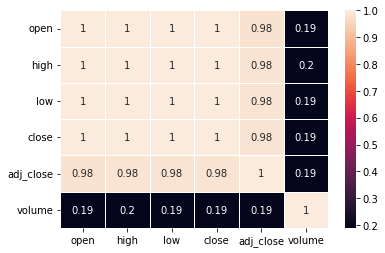

In [12]:
# Pretty obvious correlations
sns.heatmap(training_data.corr(), annot=True, linewidths=.5)
plt.show()

In [13]:
# Listing only the features which are interesting for us
features = ['open', 'high', 'low', 'close', 'adj_close']

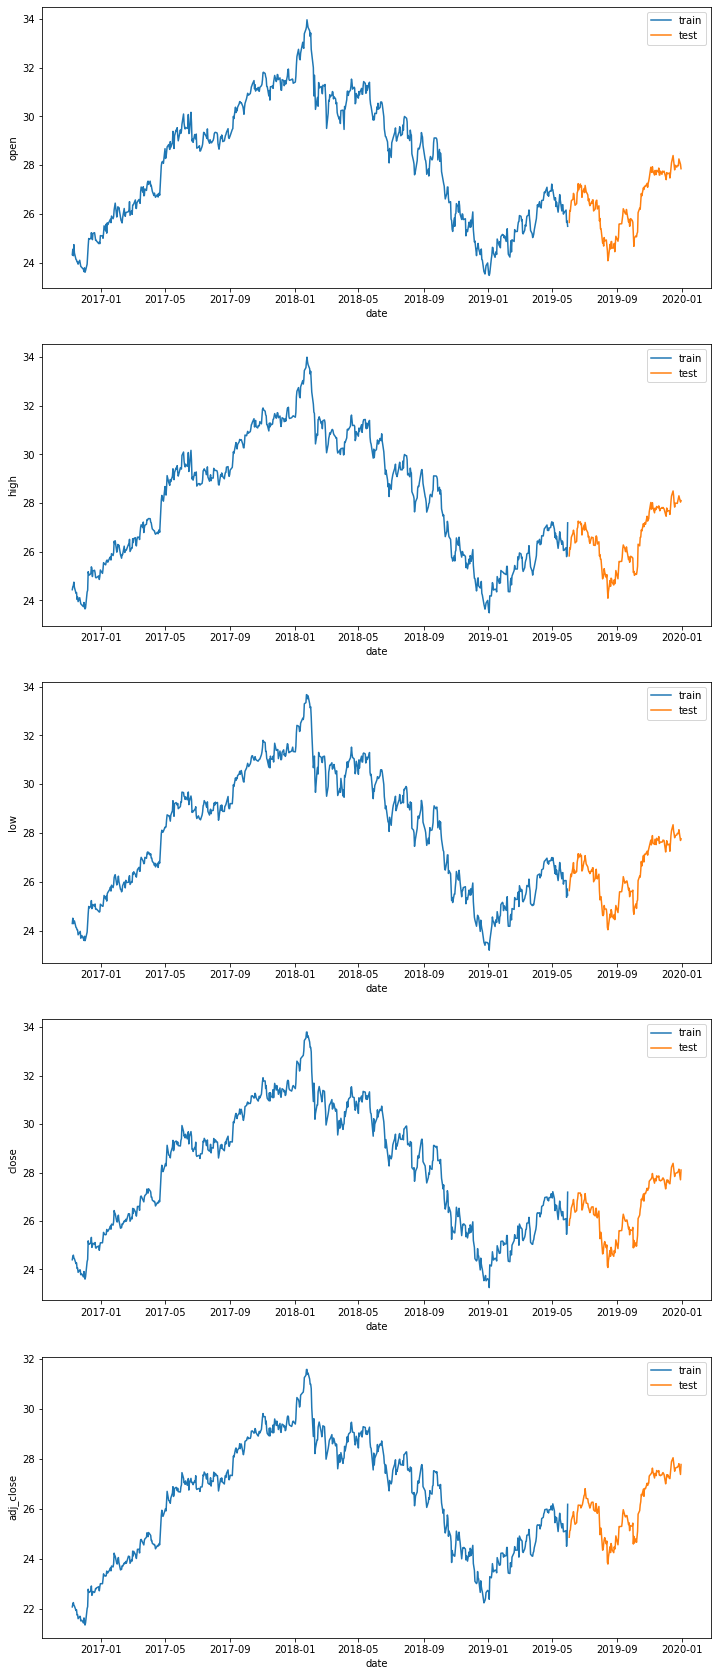

In [14]:
# Plotting all features (training and testing data)
figure, axs = plt.subplots(nrows=len(features), ncols=1, figsize=(12, 6 * len(features)))

index = 0
for feature in features:
    sns.lineplot(x=training_data.index, y=feature, data=training_data, ax=axs[index], label="train")
    sns.lineplot(x=testing_data.index, y=feature, data=testing_data, ax=axs[index], label="test")
    axs[index].legend()
    index += 1

plt.show()

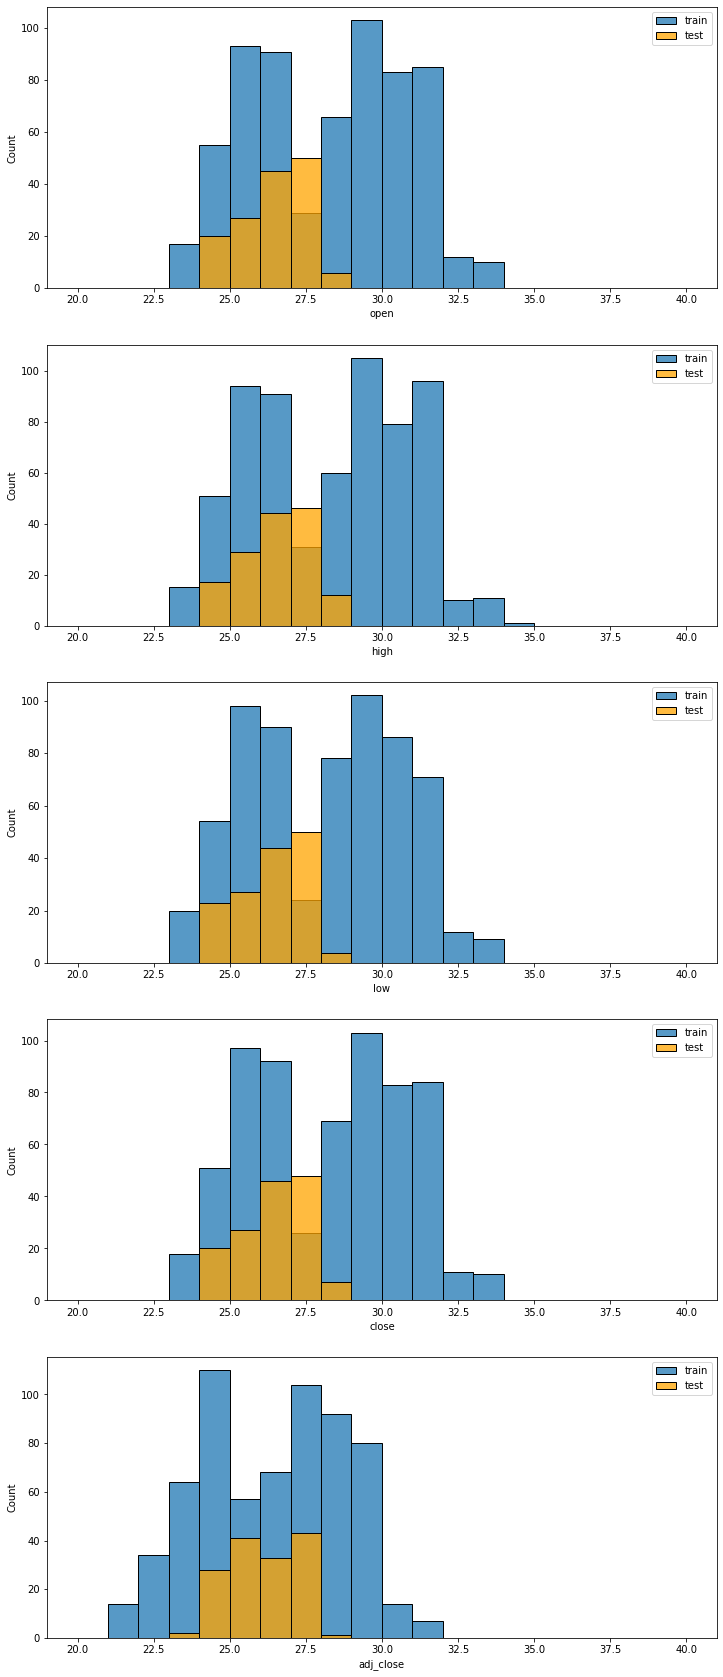

In [15]:
# Let's see what are the distributions in each feature
# We'll also plot yellow test dataset distribution for comparison
figure, axs = plt.subplots(nrows=len(features), ncols=1, figsize=(12, 6 * len(features)))

index = 0
for feature in features:
    sns.histplot(x=feature, data=training_data, binwidth=1, binrange=(20, 40), label="train", ax=axs[index])
    sns.histplot(x=feature, data=testing_data, binwidth=1, binrange=(20, 40), color="orange", label="test", ax=axs[index])
    axs[index].legend()
    index += 1

plt.show()

Utilizing Augmented Dickey-Fuller test on `"open"` feature to reject $H_{0}$ null hypothesis that time series is stationary.

_Spoiler alert: It's not stationary._

In [16]:
# Computing the result of Augmented Dickey-Fuller test
result = adfuller(training_data["open"], autolag='AIC')

# Null Hypothesis
print("Ho: \"Series is non-stationary or series has a unit root.\"\n")

# ADF test statistic
print(f"ADF Statistic: {result[0]}")

# p-value
print(f"p-value: {result[1]}")

# Critical Values:
print(f"Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}: {value}")

# Conditions to Reject Null Hypothesis(Ho)
#
# If Test statistic < Critical Value and p-value < 0.05 – Reject Null Hypothesis(Ho)
# i.e., time series does not have a unit root, meaning it is stationary.
# It does not have a time-dependent structure.
#
# Source: https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/

if (result[0] < min(
                    [result[4]["10%"],
                     result[4]["5%"],
                     result[4]["1%"]]
                    )
    ) and (result[1] < 0.05):
    print ("\nReject Ho.")
else:
    print ("\nFailed to Reject Ho.")

Ho: "Series is non-stationary or series has a unit root."

ADF Statistic: -1.482508107425776
p-value: 0.5421459018311114
Critical Values:
	1%: -3.4405768522418607
	5%: -2.8660524488494903
	10%: -2.569173076930542

Failed to Reject Ho.


__Comment on the result__:

When the test statistic is lower than the critical value shown, you reject the null hypothesis and infer that the time series is stationary.  
The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

I will now use ACF and PACF on the same feature (_open_) to see if there are some autocorrelated lags.

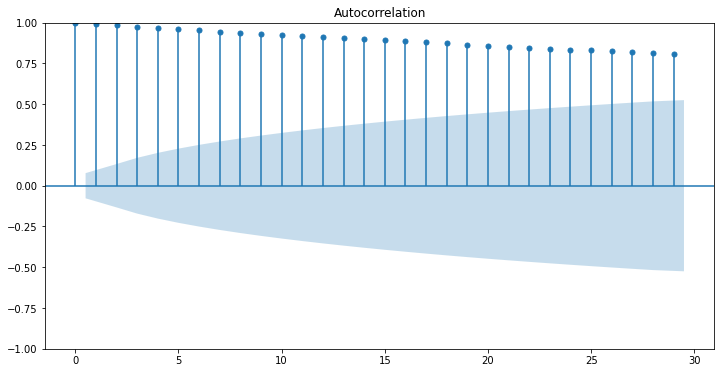

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
plot_acf(training_data["open"], ax=ax)
plt.show()

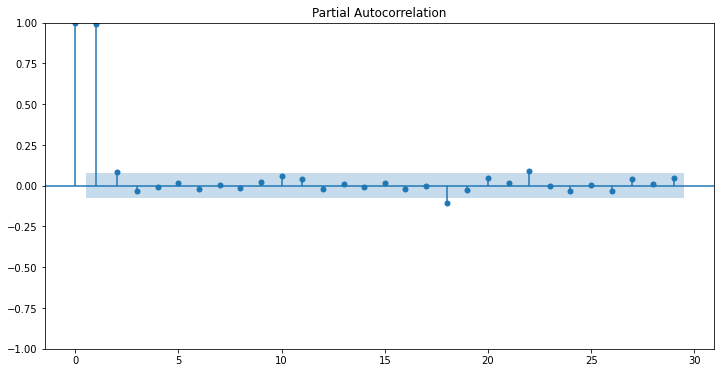

In [18]:
fig, ax = plt.subplots(figsize=(12,6))
plot_pacf(training_data["open"], method='ywm', ax=ax)
plt.show()

__Important!__

Unlike _ARIMA_ models, with _RNNs_ we don't actually need to care whether the data is stationary or not.

#### Preprocessing the data, extracting the features, and normalising the features using `preprocessing.MinMaxScaler` function from sklearn

We have provided you with the relevant function here. But we expect you to explore the data generated. 

What are the shapes?

Do a test whether features and labels correspond, i.e. whether the label for each sequence is the value following that sequence? 

Optional: Extend the function to include more features - and change it 
to choose a different column as target, i.e. adj_close


The quest now limits the features to just one column - _open_

In [19]:
# Setting now what quests wants to work with:
features = ["open"]
target   = ["open"]
sequence_length = 60

# Limiting the training and testing data to "open" column 
# These two lines are not needed after I finish the create_features_labels function
# training_data_processed = np.array(training_data[features].values)
# testing_data_processed = np.array(testing_data[features].values)

This function was provided by quest author:

In [20]:
def create_features_labels(training_data, testing_data, scaler=MinMaxScaler(feature_range = (0, 1)), sequence_length=60):
    """
    Create feature and labels from training data
    :param training_data
    :param testing_data
    :param sequence_length
    :param scaler
    :return: Features and labels sets, and labels bins
    """
    features_set = []
    labels = []
    labels_bin = []
    test_features = []
    # Limiting the training and testing data to relevant column (here "open" column)
    training_data_processed = training_data.iloc[:, 1:2].values
    # Normalization: Transform features by scaling each feature in training to be in a range of (0, 1)
    training_data_processed = scaler.fit_transform(training_data_processed)
    # Preparing training data features and labels
    for i in range(sequence_length, len(training_data)):
        features_set.append(training_data_processed[i-sequence_length:i, 0])
        labels.append(training_data_processed[i, 0])
        # Fill binary labels
        if training_data_processed[i,0] > training_data_processed[i-1,0]:
            labels_bin.append(1)
        else:
            labels_bin.append(0)
    # Preparing the testing data features
    total = pd.concat((training_data['open'], testing_data['open']), axis=0)
    test_inputs = total[len(total) - len(testing_data) - sequence_length:].values
    test_inputs = test_inputs.reshape(-1,1)
    test_inputs = scaler.transform(test_inputs)

    for i in range(sequence_length, len(test_inputs)):
        test_features.append(test_inputs[i-sequence_length:i, 0])
    
    test_features = np.array(test_features)
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
    features_set, labels, labels_bin = np.array(features_set), np.array(labels), np.array(labels_bin)
    return np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1)), labels, labels_bin, test_features, scaler

This one is extended (i.e.: includes more features - and can choose an arbitrary column as target, e.g. `adj_close`):

In [21]:
def create_features_labels(
    training_data,
    testing_data,
    features,
    target,
    sequence_length=60,
    scaler=MinMaxScaler(feature_range=(0, 1))
):
    """
    Create feature and labels from training data
    :param training_data   (pandas.DataFrame)
    :param testing_data    (pandas.DataFrame)
    :param features        (list)
    :param target          (string)
    :param sequence_length (int)
    :param scaler          (sklearn scaler object)
    :return: Features and labels sets, and labels bins
    """

    # Output
    # - train_features_out:
    #   training set shaped to (num_sequences, sequence_size, num_features)
    #   num_sequences = training set size - sequence_size
    # - train_labels_out:
    #   labels for each sequence (num_sequences, 1)
    # - train_bin_labels_out:
    #   label that says whether the next day the label was
    #   higher (value=1) or lower than previous one (value=0)
    # - test_features_out:
    #   testing set shaped to (num_sequences, sequence_size, num_features)
    #   num_sequences = testing set size - sequence_size
    train_features_out   = []
    train_labels_out     = []
    train_bin_labels_out = []
    test_features_out    = []
    test_labels_out      = []

    # Filtering only the needed features into a numpy arrays
    train_features = training_data[features].values
    train_labels   = training_data[target].values
    test_features  = testing_data[features].values
    test_labels    = testing_data[target].values

    # Scaling the data using the provided scaler
    train_features = scaler.fit_transform(train_features)
    test_features  = scaler.transform(test_features)

    # Scaling training labels using the provided scaler
    train_labels   = scaler.transform(train_labels)
    test_labels    = scaler.transform(test_labels)

    # Now all these datasets are numpy arrays:
    # - train_features
    # - train_labels
    # - test_features
    # - test_labels

    train_size = len(train_features)
    test_size  = len(test_features)

    # Iterating through training set to make all sequences:
    #   The - 1 in the end counts for the target. Because the last sentence must have a target from future.
    #   So the last target comes from last element of the trainins set, so we have N - 1 sequences,
    #   where N is the <train_size - sequence_length>

    for i in range(train_size - sequence_length - 1):
        
        # Appending a sequence of train_features
        train_features_out.append(train_features[i:i+sequence_length])

        # Appending a label for the sequence
        train_labels_out.append(train_labels[i+sequence_length])

        # Calculating a binary label for the sequence
        if train_labels[i+sequence_length] > train_labels[i+sequence_length-1]:
            train_bin_labels_out.append([1])
        else:
            train_bin_labels_out.append([0])

    # Iterating through testing set to make all sequences.
    # Note: We need to get some data from training set, so we can create all the testing sequences.
    #       More precisely, we need final (sequence_length - 1) observations from training set
    #       to prepend before the testing set, so we can make first sequences
    
    # Last N-1 train observations -> [1-N:] joined to entire test observations
    total_features = np.concatenate((train_features[1-sequence_length:], test_features))

    for i in range(test_size):

        # Appending a sequence of total_features
        test_features_out.append(total_features[i:i+sequence_length])
        
    # All output variables are now lists, we need to cast them as numpy arrays
    train_features_out   = np.array(train_features_out)
    train_labels_out     = np.array(train_labels_out)
    train_bin_labels_out = np.array(train_bin_labels_out)
    test_features_out    = np.array(test_features_out)
    test_labels_out      = np.array(test_labels)

    return train_features_out, train_labels_out, train_bin_labels_out, test_features_out, test_labels_out, scaler   

In [22]:
# Now we'll run this cool new function to create our input data in sequences:
(
    train_features,
    labels,
    labels_bin,
    test_features,
    test_labels,
    scaler,
) = create_features_labels(
    training_data,
    testing_data,
    features,
    target,
    sequence_length,
    MinMaxScaler(feature_range=(0, 1)),
)


In [23]:
# What are the shapes of the data?
print(f"Train features = {train_features.shape}")
print(f"Labels         = {labels.shape}")
print(f"Labels bin     = {labels_bin.shape}")
print(f"Test features  = {test_features.shape}")
print(f"Test labels    = {test_labels.shape}")

Train features = (583, 60, 1)
Labels         = (583, 1)
Labels bin     = (583, 1)
Test features  = (148, 60, 1)
Test labels    = (148, 1)


In [24]:
# This is second sequence - the last element should be equal to first label
scaler.inverse_transform(train_features[1])[-1]

array([26.27])

In [25]:
scaler.inverse_transform(labels)[0]

array([26.27])

In [26]:
# Do a test whether features and labels correspond, i.e. whether the label for each sequence is the value following that sequence? 

err_count = 0

# len(labels)-1 because we omit first sequence (doesn't contain first label occurence)
for i in range(len(labels)-1):
    if train_features[i+1][-1] != labels[i]:
        err_count += 1
        print(f"Last feature of the sequence: {train_features[i+1][-1]} ~ {labels[i]} :Label")

print(f"Errors found: {err_count}")

Errors found: 0


### Model
In this section we ask you to build and train a LSTM neural network and use it predict the stock price variations on your testing data.

In [28]:
def lstm_model(input_shape):
  #write code here
  #for simplicity you can use the default stateful argument in the LSTM layer and not worry about this argument here

  # Create Sequential model
  model = Sequential()

  # Input object
  inputs = tf.keras.Input(shape=input_shape)
  model.add(inputs)

  # LSTM layer (5 units)
  model.add(LSTM(5))
  model.add(Dropout(0.2))

  # Output layer (binary classification)
  model.add(Dense(1, activation="linear"))

  return model

Compile your model, train it and evaluate it. 

What is your mse - and what is your accuracy (note that you have two different types of labels readily available to you). 



In [ ]:
train_features.shape

(583, 60, 1)

__Warning!!__

If you specify `return_sequences=True`, then the model will no longer predict a scalar (1 value), but a vector (M values). Also special considerations need to be done.

For further reading check this article: [Multi-Step LSTM Time Series Forecasting Models for Power Usage](https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/).

In [29]:
# Compile code here
m1 = lstm_model((sequence_length, 1))

m1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()]
)

m1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5)                 140       
_________________________________________________________________
dropout (Dropout)            (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Training
h1 = m1.fit(train_features, labels, batch_size=32, epochs=20, verbose=1)

Epoch 1/20
19/19 [==============================] - 5s 36ms/step - loss: 0.2010 - mean_squared_error: 0.2010
Epoch 2/20
19/19 [==============================] - 1s 42ms/step - loss: 0.0976 - mean_squared_error: 0.0976
Epoch 3/20
19/19 [==============================] - 1s 34ms/step - loss: 0.0424 - mean_squared_error: 0.0424
Epoch 4/20
19/19 [==============================] - 1s 35ms/step - loss: 0.0336 - mean_squared_error: 0.0336
Epoch 5/20
19/19 [==============================] - 1s 33ms/step - loss: 0.0313 - mean_squared_error: 0.0313
Epoch 6/20
19/19 [==============================] - 1s 31ms/step - loss: 0.0294 - mean_squared_error: 0.0294
Epoch 7/20
19/19 [==============================] - 1s 32ms/step - loss: 0.0249 - mean_squared_error: 0.0249
Epoch 8/20
19/19 [==============================] - 1s 32ms/step - loss: 0.0246 - mean_squared_error: 0.0246
Epoch 9/20
19/19 [==============================] - 1s 36ms/step - loss: 0.0245 - mean_squared_error: 0.0245
Epoch 10/20
19/19 [

In [31]:
m1.predict(train_features, batch_size=583)[0:2]

array([[0.26090193],
       [0.26361516]], dtype=float32)

In [35]:
#Make predictions and inverse the scaling

# finish the code 
predicted_stock_price = m1.predict(test_features)
predicted_stock_price_inverse = scaler.inverse_transform(predicted_stock_price)

In [40]:
testing_data["prediction"] = predicted_stock_price_inverse

In [38]:
predicted_stock_price_inverse.shape

(148, 1)

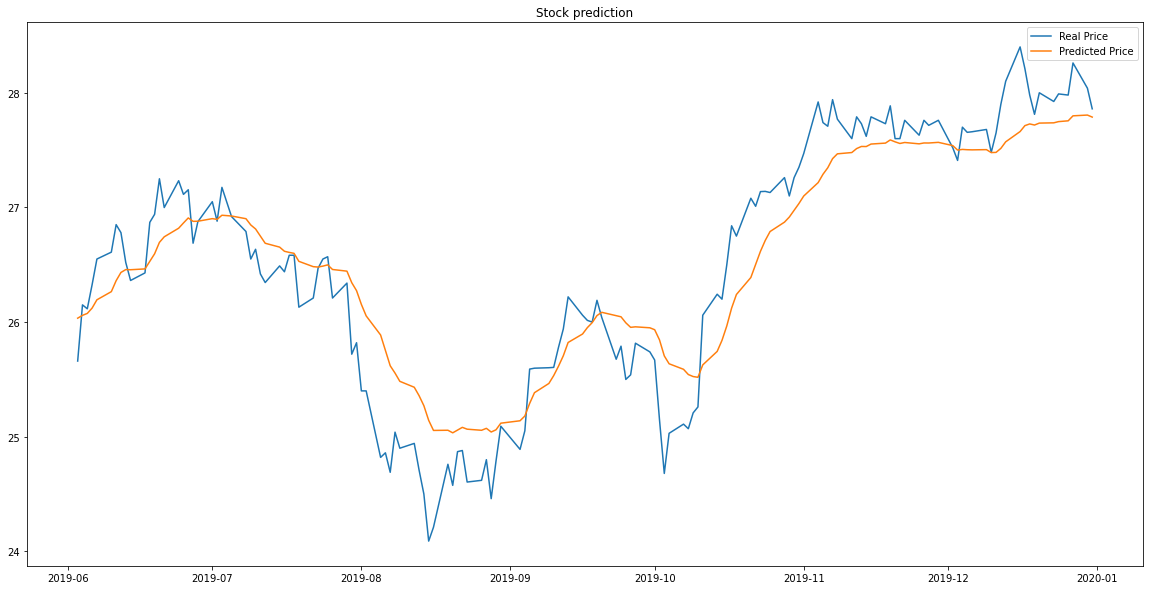

In [42]:
#Plot predictions vs. reality on Test Data
plt.figure(figsize=(20,10))
plt.plot(testing_data[target], label = 'Real Price')
plt.plot(testing_data["prediction"], label = 'Predicted Price')
plt.title('Stock prediction')
plt.legend()
plt.show()

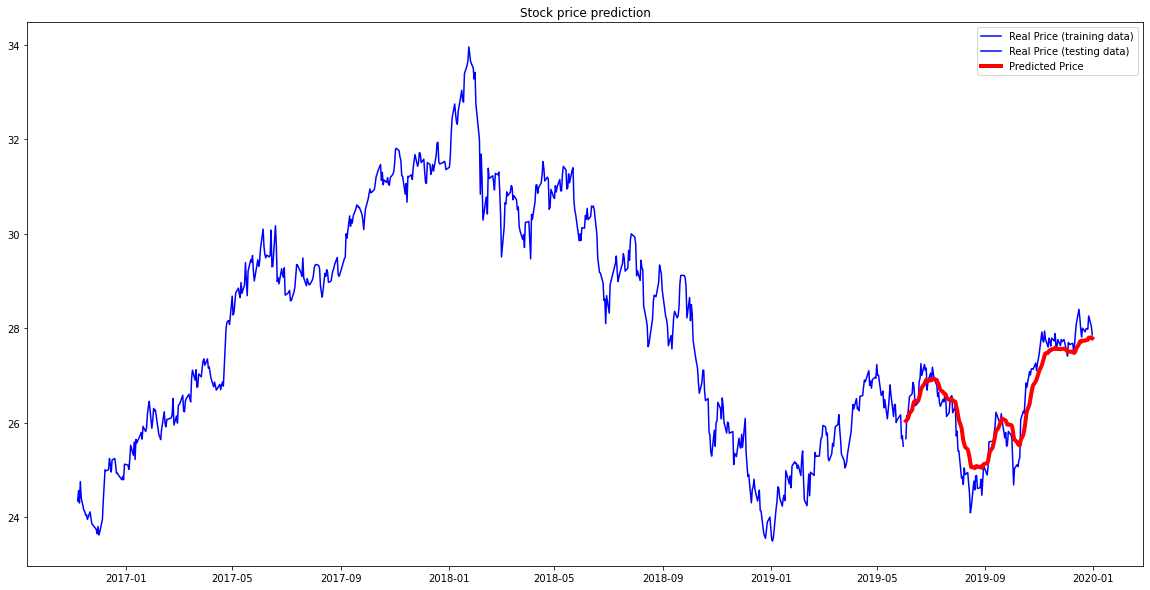

In [52]:
# Plot the whole Stock Price time series, including train and forecasted test

# Plot "in time"
plt.figure(figsize=(20,10))
plt.plot(training_data[target], label = "Real Price (training data)", color="blue")
plt.plot(testing_data[target], label = "Real Price (testing data)", color="blue")
plt.plot(testing_data["prediction"], label = "Predicted Price", color="red", linewidth="4")
plt.title("Stock price prediction")
plt.legend()
plt.show()

Optional: Try your model with more features, try with different sequence lengths (this is a hyperparameter) - and try with the "real" Dax Performance Index data also provided (which reaches back longer). If you do so, you will have to split the data into training and test sets first). 

<iframe src="https://giphy.com/embed/STfLOU6iRBRunMciZv" width="480" height="270" frameBorder="0" class="giphy-embed" allowFullScreen></iframe><p><a href="https://giphy.com/gifs/adweek-no-way-how-bout-STfLOU6iRBRunMciZv"></a>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87989bd7-7a25-4e61-b3c0-cb24ea7ca1f8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>